In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add





BASE_DIR = 'D:/research/dataset'
with open(os.path.join(BASE_DIR, 'Flickr8k.lemma.token.txt'), 'r') as f:
    
    captions_doc = f.read()


In [2]:
WORKING_DIR = 'D:/research'
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features19.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(' ')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)


In [4]:
len(mapping)

8091

In [5]:
mapping['1305564994_00513f9a5b']

["man in street racer armor be examine the tire of another racer 's motorbike .",
 'racer drive a white bike down a road .',
 'motorist be ride along on their vehicle that be oddly design and color .',
 'person be in a small race car drive by a green hill .',
 'person in race uniform in a street car .']

In [5]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [31]:
mapping['1305564994_00513f9a5b']

["man in street racer armor be examine the tire of another racer 's motorbike .",
 'racer drive a white bike down a road .',
 'motorist be ride along on their vehicle that be oddly design and color .',
 'person be in a small race car drive by a green hill .',
 'person in race uniform in a street car .']

In [6]:
clean(mapping)

In [7]:
mapping['1305564994_00513f9a5b']

["startseq man in street racer armor be examine the tire of another racer 's motorbike endseq",
 'startseq racer drive white bike down road endseq',
 'startseq motorist be ride along on their vehicle that be oddly design and color endseq',
 'startseq person be in small race car drive by green hill endseq',
 'startseq person in race uniform in street car endseq']

In [8]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
all_captions[:10]

["startseq man in street racer armor be examine the tire of another racer 's motorbike endseq",
 'startseq racer drive white bike down road endseq',
 'startseq motorist be ride along on their vehicle that be oddly design and color endseq',
 'startseq person be in small race car drive by green hill endseq',
 'startseq person in race uniform in street car endseq',
 'startseq firefighter extinguish fire under the hood of car endseq',
 'startseq fireman spray water into the hood of small white car on jack endseq',
 'startseq fireman spray inside the open hood of small white car on jack endseq',
 'startseq fireman use firehose on car engine that be up on carjack endseq',
 'startseq use water to extinguish car that be on fire endseq']

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [10]:
vocab_size = 6348

In [11]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length 

33

In [12]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]


In [13]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length) [0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 
                       num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(), list(), list()
                    n = 0


In [40]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

In [41]:
# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [42]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [43]:
# train the model
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 1037s 5s/step - loss: 2.6903


In [17]:
from tensorflow.keras.models import load_model
model = load_model('D:/research/vgg19model.h5')

In [ ]:
batch_size = 32
steps = len(train) // batch_size

# create data generator
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# fit for one epoch
tes_acc,test_loss=model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
test_acc

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.epoch, model.history[metric], label='Train')
#plt.plot(model.epoch, model.history['val_'+metric], linestyle="--",label='Val')
plt.xlabel('Epoch')
plt.ylabel(name)

In [18]:
from tensorflow.keras.models import load_model
model = load_model('D:/research/vgg19model.h5')

In [23]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

202/202 [==============================] - 1640s 8s/step - loss: 2.1475


In [24]:
model.save(WORKING_DIR+'/vgg19model.h5')

In [22]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0, 1.0, 0, 0)))

In [25]:
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0, 1.0, 0, 0)))

BLEU-1: 0.603293
BLEU-2: 0.230356


In [26]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "55470226_52ff517151.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('D:/research/Flicker8k_Dataset', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq climber stop to take drink while climb snow cover mountain endseq
startseq man hold cup on snow mountain endseq
startseq man in yellow suit be hold up cup while stand in snow endseq
startseq mountain climber stop for drink endseq
startseq mountaineer in yellow jacket be drink from thermos cup endseq
--------------------Predicted--------------------
startseq little boy in red and white snowsuit be ride on the pavement endseq


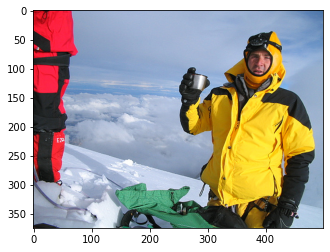

In [27]:
generate_caption("55470226_52ff517151.jpg")

---------------------Actual---------------------
startseq group of child run footrace in the snow endseq
startseq group of young boy race on snowy day endseq
startseq kid race in the snow endseq
startseq be run in the snow with fence in the background endseq
startseq runner be race through the snow endseq
--------------------Predicted--------------------
startseq little boy in red shirt be play in the snow endseq


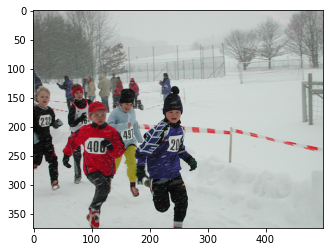

In [28]:

generate_caption("72218201_e0e9c7d65b.jpg")

---------------------Actual---------------------
startseq brown dog be run through brown field endseq
startseq brown dog be run through the field endseq
startseq brown dog with collar run in the dead grass with his tongue hang out to the side endseq
startseq brown dog with his tongue wag as he run through field endseq
startseq dog run in the grass endseq
--------------------Predicted--------------------
startseq small brown dog be run through the grass endseq


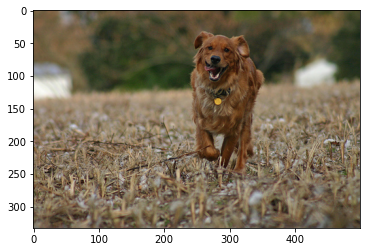

In [29]:
generate_caption("69189650_6687da7280.jpg")

---------------------Actual---------------------
startseq small dog run through the grass endseq
startseq fluffy white dog run in green grass endseq
startseq small dog run through the grass endseq
startseq small dog that look almost identical be play in the grass endseq
startseq yellow dog run together in green grass endseq
--------------------Predicted--------------------
startseq small girl in pink and white are be play in the grass endseq


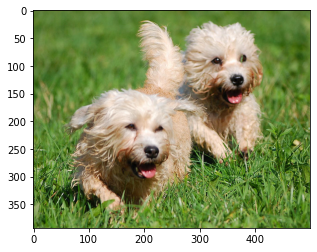

In [31]:
generate_caption("263854883_0f320c1562.jpg")

---------------------Actual---------------------
startseq girl in red polka dot bikini be jump off sand dune endseq
startseq girl with bikini play in dune endseq
startseq little girl in pink bathe suit jump up on sand dune at beach endseq
startseq young girl in bikini jump on beach endseq
startseq young girl in pink bikini jump into the air on sandy beach by the ocean as two other child play in the sand endseq
--------------------Predicted--------------------
startseq boy in pink shirt be jump into the air endseq


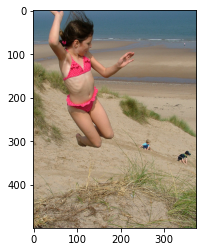

In [32]:
generate_caption("322103537_184367bf88.jpg")

In [ ]:
def sea(arr,x,n):
    step = math.sqrt(n)
    
    while arr[int(min(step,n)-1)]<x:
        prev = step
        step += math.sqrt(n)
        if prev >=n:
            return -1
        







arr = [ 0, 1, 1, 2, 3, 5, 8, 13, 21,
    34, 55, 89, 144, 233, 377, 610 ]
x = 55
n = len(arr)

In [5]:
# Python3 code to implement Jump Search
import math

def jumpSearch( arr , x , n ):
	# Finding block size to be jumped
	step = math.sqrt(n)
	
	# Finding the block where element is
	# present (if it is present)
	prev = 0
	while arr[int(min(step, n)-1)] < x:
		prev = step
		step += math.sqrt(n)
		if prev >= n:
			return -1
	
	# Doing a linear search for x in
	# block beginning with prev.
	while arr[int(prev)] < x:
		prev += 1
		
		# If we reached next block or end
		# of array, element is not present.
		if prev == min(step, n):
			return -1
	
	# If element is found
	if arr[int(prev)] == x:
		return prev
	
	return -1

# Driver code to test function
arr = [ 0, 1, 1, 2, 3, 5, 8, 13, 21,
	34, 55, 89, 144, 233, 377, 610 ]
x = 55
n = len(arr)

# Find the index of 'x' using Jump Search
index = jumpSearch(arr, x, n)

# Print the index where 'x' is located
print("Number" , x, "is at index" ,"%.0f"%index)

# This code is contributed by "Sharad_Bhardwaj".


Number 55 is at index 4
